# Use continuous wavelet transform to perform time-frequency analysis of the hammer-shot signals

In [1]:
# Import modules
from os.path import join
from obspy import read, UTCDateTime
from numpy import amax, abs, linspace, arange, log10
from pandas import DataFrame, Timedelta, Timestamp
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
from pywt import scale2frequency, cwt

from utils_basic import ROOTDIR
from utils_hammer import get_timewin_from_hammer_name
from utils_preproc import read_and_process_windowed_waveforms
from utils_snuffler import read_phase_markers
from utils_spec import get_data_spectrum, get_data_psd, get_filter_response

In [2]:
# Inputs
## Time windows and stations
station = "A04"
name = "Hammer10-00-15"

begin_read = -0.5
end_read = 1.5

## Parameters for the wavelet transform
bandwidth = 30.0
centerfreq = 1.0
wavelet = f"cmor{bandwidth}-{centerfreq}"
#wavelet = "mexh"

scales = linspace(1, 100, 401)

## Filtering paramgters
freqmin_filt = 10.0
freqmax_filt = 450.0

## Plotting parameters
linewidth_wf = 1.0
linewidth_psd = 1.5

freqmin_plot = 10.0
freqmax_plot = 200.0

timemin_plot = -0.1
timemax_plot = 0.25

freq1_plot = 85.0
freq2_plot = 105.0
freq3_plot = 125.0

loc_cbar = [0.44, 0.025, 0.15, 0.015]


## Scale factors for plotting the waveforms and PSDs
scale_wf = 1.05
scale_psd = 3.0

psdmin = 1e-2

In [3]:
# Read the snuffler pick file
timewin = get_timewin_from_hammer_name(name)
pickdf = read_phase_markers(join(ROOTDIR, timewin, f"Ppicks_{name}.dat"))

In [4]:
# Read and process the data
stream = read_and_process_windowed_waveforms(pickdf, freqmin_filt, freqmax_filt, begin=begin_read, end=end_read, stations=[station])

A04


In [5]:
# Compute the continuous wavelet transform

## Get the traces
trace_z = stream.select(station=station, component="Z")[0]
trace_1 = stream.select(station=station, component="1")[0]
trace_2 = stream.select(station=station, component="2")[0]

data_z = trace_z.data
data_1 = trace_1.data
data_2 = trace_2.data

samprat = trace_z.stats.sampling_rate
sampint = trace_z.stats.delta
timeax = trace_z.times()+begin_read


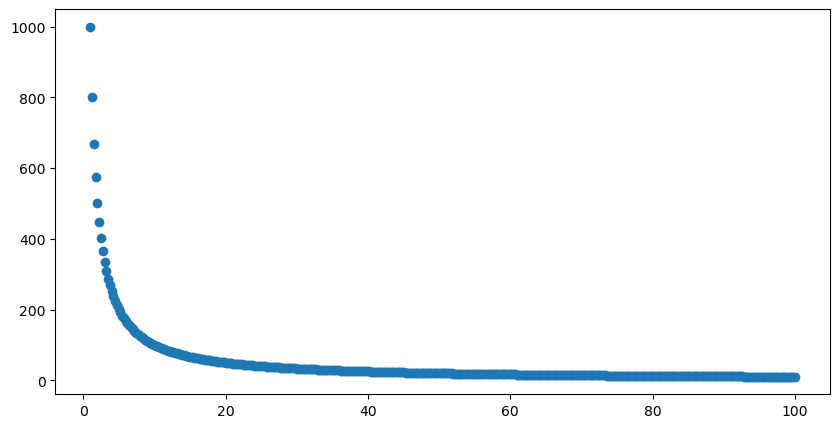

In [6]:
## Visualize the frequencies
freqs = scale2frequency(wavelet, scales) / sampint
fig, ax = subplots(1, figsize=(10, 5))
ax.scatter(scales, freqs)

In [7]:
## Compute the CWT
cwtmatr_z, _ = cwt(data_z, scales, wavelet, sampint)
cwtmatr_1, _ = cwt(data_1, scales, wavelet, sampint)
cwtmatr_2, _ = cwt(data_2, scales, wavelet, sampint)

cwtmax = max(amax(abs(cwtmatr_z)), amax(abs(cwtmatr_1)), amax(abs(cwtmatr_2)))
cwtmatr_z = log10(abs(cwtmatr_z) / cwtmax)
cwtmatr_1 = log10(abs(cwtmatr_1) / cwtmax)
cwtmatr_2 = log10(abs(cwtmatr_2) / cwtmax)

Figure saved to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-25-10-00-00/cwt_Hammer10-00-15_A04.png


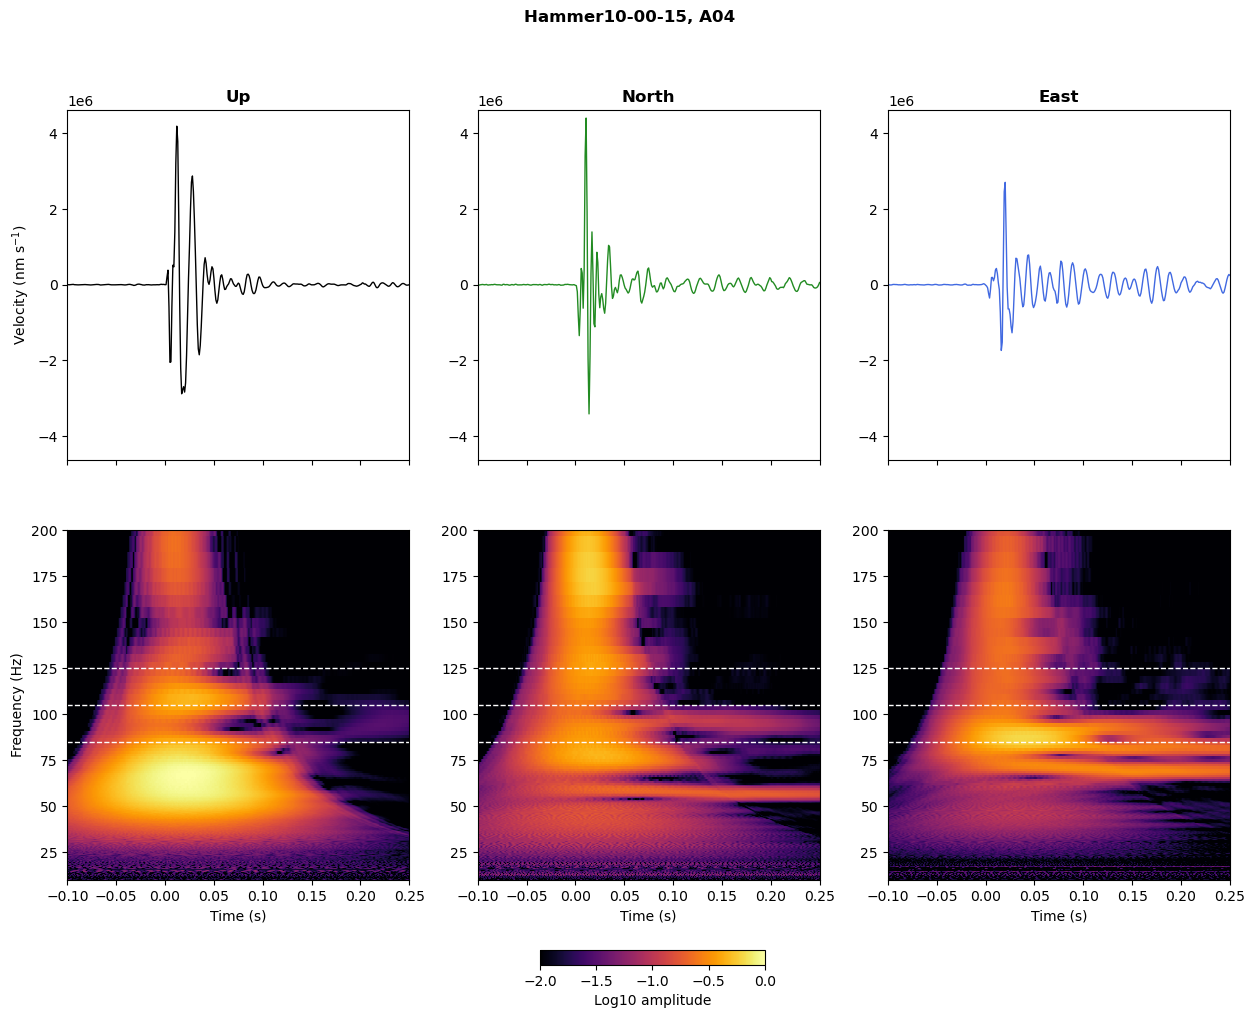

In [8]:
## Visualize the waveforms and the CWT
fig, axes = subplots(2, 3, figsize=(15, 10), sharex=True)

## Plot the waveforms
wfmax = max([amax(abs(data_z)), amax(abs(data_1)), amax(abs(data_2))])

ax = axes[0, 0]
ax.plot(timeax, data_z, linewidth=linewidth_wf, color='black')
ax.set_xlim(timemin_plot, timemax_plot)
ax.set_ylim(-scale_wf*wfmax, scale_wf*wfmax)
ax.set_title(f"Up", fontweight='bold')
ax.set_ylabel("Velocity (nm s$^{-1}$)")

ax = axes[0, 1]
ax.plot(timeax, data_1, linewidth=linewidth_wf, color='forestgreen')
ax.set_xlim(timemin_plot, timemax_plot)
ax.set_ylim(-scale_wf*wfmax, scale_wf*wfmax)
ax.set_title(f"North", fontweight='bold')

ax = axes[0, 2]
ax.plot(timeax, data_2, linewidth=linewidth_wf, color='royalblue')
ax.set_xlim(timemin_plot, timemax_plot)
ax.set_ylim(-scale_wf*wfmax, scale_wf*wfmax)
ax.set_title(f"East", fontweight='bold')

## Plot the CWTs
ax = axes[1, 0]
cmap = ax.pcolormesh(timeax, freqs, cwtmatr_z, shading='auto', cmap='inferno', vmin=-2, vmax=0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')

ax.axhline(freq1_plot, color='w', linestyle='--', linewidth=1)
ax.axhline(freq2_plot, color='w', linestyle='--', linewidth=1)
ax.axhline(freq3_plot, color='w', linestyle='--', linewidth=1)

ax.set_xlim(timemin_plot, timemax_plot)
ax.set_ylim(freqmin_plot, freqmax_plot)
ax.set_xlabel("Time (s)")

ax = axes[1, 1]
ax.pcolormesh(timeax, freqs, cwtmatr_1, shading='auto', cmap='inferno', vmin=-2, vmax=0)
ax.set_xlabel('Time (s)')

ax.axhline(freq1_plot, color='w', linestyle='--', linewidth=1)
ax.axhline(freq2_plot, color='w', linestyle='--', linewidth=1)
ax.axhline(freq3_plot, color='w', linestyle='--', linewidth=1)

ax.set_xlim(timemin_plot, timemax_plot)
ax.set_ylim(freqmin_plot, freqmax_plot)
ax.set_xlabel("Time (s)")

ax = axes[1, 2]
ax.pcolormesh(timeax, freqs, cwtmatr_2, shading='auto', cmap='inferno', vmin=-2, vmax=0)
ax.set_xlabel('Time (s)')

ax.axhline(freq1_plot, color='w', linestyle='--', linewidth=1)
ax.axhline(freq2_plot, color='w', linestyle='--', linewidth=1)
ax.axhline(freq3_plot, color='w', linestyle='--', linewidth=1)

ax.set_xlim(timemin_plot, timemax_plot)
ax.set_ylim(freqmin_plot, freqmax_plot)
ax.set_xlabel("Time (s)")

fig.suptitle(f"{name}, {station}", fontweight='bold')

## Add colorbar
cbar_ax = fig.add_axes(loc_cbar)
cbar = fig.colorbar(cmap, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Log10 amplitude", fontsize=10)

## Save the figure
figname = f"cwt_{name}_{station}.png"
outpath = join(ROOTDIR, timewin, figname)
fig.patch.set_alpha(0)

fig.savefig(outpath, dpi=300)
print(f"Figure saved to {outpath}")
